In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder

%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

This part of the exploratory comoponent will try to answer the question: can the end station of a trip be predicted starting from a single known station?
It is our belief that this is a hugely interesting topic to inverstigate, which will be done through two of the techniques learnt during the course: neural networks and a Tree Forest Classifier. 

First of all, all the relevant data needs to be loaded, which includes the pickups information as well as the wheather data and national holidays dates, which will be added as a column with a binary value (1 indicating that the day is indeed a national holiday and 0 otherwise).
Once this is achieved, both dataframes will be merged by date. Since the nature of this problem calls for keeping each pickup as a separate instance in the dataframe, the merge will happen on the pickups data side.


In [4]:
data_exp=pd.read_csv('BikeSharing_Bluebikes2022.csv')
nat_hol = ['2022-01-01','2022-01-17','2022-02-21','2022-04-17','2022-04-18','2022-05-08','2022-05-30','2022-06-19','2022-06-20','2022-07-04']

data_exp['is_Holiday'] = [ 1 if data_exp.iloc[i]['starttime'][0:10] in nat_hol else 0 for i in range(len(data_exp))]


As we have seen before, there is data in the wheather dataframe which is highly correlated with each other, like 'temp' and 'tempmax' for example, while others are not relevant at all to our study. All of these features will be dropped.

In [5]:
data_w = pd.read_csv("Boston 2022-01-01 to 2022-08-31.csv")
drop = ['dew', 'sunrise','sunset','moonphase','conditions', 'description','stations','sealevelpressure',
'windgust','severerisk', 'uvindex', 'solarenergy', 'solarradiation','preciptype','winddir','name'
,'tempmax', 'tempmin','feelslikemax', 'feelslikemin','precipprob', 'precipcover']
data_w = data_w.drop(columns = drop)
data_w['datetime'] = pd.to_datetime(data_w['datetime'])

In [6]:
from datetime import datetime as dt

data_exp['starttime'] = pd.to_datetime(data_exp['starttime'], format='%Y-%m-%d %H:%M:%S')
data_exp['datetime'] = pd.to_datetime(data_exp['starttime']).dt.date
data_exp['datetime'] = pd.to_datetime(data_exp['datetime'])

data_merge = data_exp.merge(data_w, how='left', on='datetime')

In [7]:
data_merge.columns
data_merge = data_merge.drop(columns=(['Unnamed: 0']))

In [8]:
data_merge.columns


Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'postal code', 'is_Holiday', 'datetime', 'temp', 'feelslike',
       'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover',
       'visibility', 'icon'],
      dtype='object')

In [9]:
data_merge['start station id']

0          178
1          189
2           94
3           94
4           19
          ... 
2305730     67
2305731    380
2305732    150
2305733    105
2305734    560
Name: start station id, Length: 2305735, dtype: int64

In order to conduct a coherent study, we need to choose the start station with sufficient data, which means counting the instances of each start station and creating a new dataframe including only those from the most repeated one.

In [10]:
list = []
for i in data_merge['start station id'].unique():
    count = data_merge[data_merge['start station id']==i].count()[0]
    list.append(count)

maxim = data_merge['start station id'].unique()[list.index(max(list))]
print(maxim)
data_merge[data_merge['start station id']==maxim].count()[0]



67


49127

In this case, station 67 happens to be the most frequent, with a total count of almost fifty thousand data points.

In [11]:
data_merge[data_merge['start station id']!=67]['start station id'].mode()

0    68
Name: start station id, dtype: int64

Since this data will be sliced further in this notebook, we are also going to include the second most frequent start station, which is number 68

In [12]:
data_merge[data_merge['start station id']==68].count()[0]

40999

In [13]:
data_merge = data_merge[data_merge['start station id'].isin([67,68])]

In [14]:
data_merge['start station id']

33         68
35         68
56         68
62         67
67         68
           ..
2305598    67
2305608    67
2305623    67
2305661    67
2305730    67
Name: start station id, Length: 90126, dtype: int64

It is also important to investigate how balanced our data is, since having a couple of end stations with a huge number of entries can lead to unclear prediction models.

In [15]:
dic_stations = {}
for i in data_merge['end station id']:
    if str(i) in dic_stations.keys():
        dic_stations[str(i)] +=1
    else:
        dic_stations[str(i)] = 1

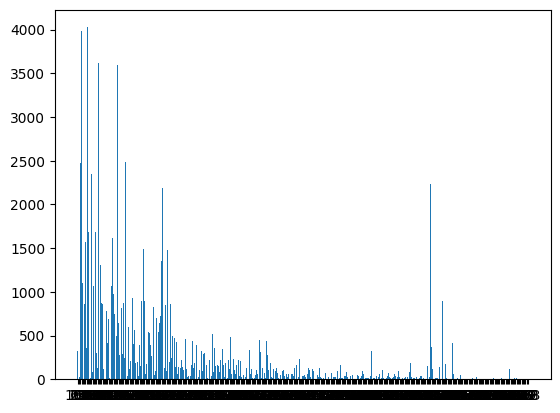

In [16]:
plot = plt.bar(*zip(*dic_stations.items()))
plt.show()

As we can see in the plot above, most of the stations have very few pickups to be relevant in this study, since it would result in an inaccurate model due to underfitting. Thus, this test case will focus on those stations that have over 2300 different data points. 

In [17]:
excluded_stations = []
for i in data_merge['end station id'].unique():
    count = data_merge[data_merge['end station id']==i].count()[0]
    if 2300 < count :
        continue
    else:
        excluded_stations.append(i)

print(len(excluded_stations),len(data_merge['end station id'].unique()))

359 366


As a result of this exploration, all but 7 stations and their respective data will be eliminated from the dataset

In [18]:
data_merge = data_merge[~data_merge['end station id'].isin(excluded_stations)]

In [19]:
len(data_merge['end station id'].unique())

7

In [59]:
data_merge['end station id'].unique()

array([107,  67, 178, 471,  68, 179,  74], dtype=int64)

Next, we also need to get rid of the unnecessary features coming from the pickups file, including the start station id since they are all from the same station now.

In [20]:
data_merge.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'postal code', 'is_Holiday', 'datetime', 'temp', 'feelslike',
       'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover',
       'visibility', 'icon'],
      dtype='object')

In [21]:
data_nn = data_merge.drop(columns=[
       'start station name', 'start station latitude',
       'start station longitude','end station name',
       'end station latitude', 'end station longitude','bikeid','postal code', 'stoptime'])

In [22]:
data_nn

,tripduration,starttime,start station id,end station id,usertype,is_Holiday,datetime,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,icon
56,509,2022-01-01 00:27:40.984,68,107,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain
62,2209,2022-01-01 00:29:15.682,67,67,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain
150,320,2022-01-01 01:18:18.033,68,178,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain
333,387,2022-01-01 03:31:04.764,68,178,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain
377,204,2022-01-01 03:56:38.414,67,471,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305014,228,2022-08-31 23:29:02.443,67,471,Subscriber,0,2022-08-31,25.0,25.0,63.1,8.351,0.0,0.0,31.6,49.3,16.0,rain
2305157,529,2022-08-31 23:35:22.510,68,471,Subscriber,0,2022-08-31,25.0,25.0,63.1,8.351,0.0,0.0,31.6,49.3,16.0,rain
2305276,494,2022-08-31 23:40:14.734,68,179,Subscriber,0,2022-08-31,25.0,25.0,63.1,8.351,0.0,0.0,31.6,49.3,16.0,rain
2305566,356,2022-08-31 23:52:55.882,67,179,Subscriber,0,2022-08-31,25.0,25.0,63.1,8.351,0.0,0.0,31.6,49.3,16.0,rain


Our data is looking like this at the moment. There are obvious steps to be taken before training of any kind can begin to occur: 
First of all, the time in which those pickups happen can not be a simple date since it can not be picked up by models. Therefore, we have decided to transform the time of the pickup into a new variable expressing the time of day in which the pickup happened. The division will happen every six hours into morning, afternoon, evening and night. These are really valuable information and more importantly, usable by getting their dummies.
Once this is done, both columns indicating the date and time of the pickup can be dropped from the dataframe.

In [23]:
data_nn['time_of_day'] = 0
for i in range(len(data_nn)):
    if (data_nn['starttime'].iloc[i].hour >= 7) & (data_nn['starttime'].iloc[i].hour < 12):
        data_nn['time_of_day'].iloc[i] = 'morning'
    elif (data_nn['starttime'].iloc[i].hour >= 12) & (data_nn['starttime'].iloc[i].hour < 17):
        data_nn['time_of_day'].iloc[i] = 'afternoon'
    elif (data_nn['starttime'].iloc[i].hour >= 17) & (data_nn['starttime'].iloc[i].hour < 24):
        data_nn['time_of_day'].iloc[i] = 'evening'
    elif (data_nn['starttime'].iloc[i].hour >= 24) or (data_nn['starttime'].iloc[i].hour < 7):
        data_nn['time_of_day'].iloc[i] = 'night'


C:\Users\mirun\AppData\Local\Temp\ipykernel_3008\1358740847.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nn['time_of_day'].iloc[i] = 'night'


We have also added another variable indicating weather the pickup was produced during the weekend or otherwise, hoping that it will add valuable information to the models and result in a higher accuracy metrics.
The cutting point for weekend has been set at Friday evening, which we belief is more precise than setting it to saturday midnight.

In [24]:
data_nn['is_weekend'] = 1  
weekday = 5 ## 2022 starts on a saturday
day = data_nn['starttime'].iloc[0].day
for i in range(1,len(data_nn)):
    data_nn['is_weekend'].iloc[i] = 1 if (
    data_nn['starttime'].iloc[i].weekday()) > 4 else 0
    if data_nn['starttime'].iloc[i].weekday() == 4 and data_nn['time_of_day'].iloc[i] == 'evening':
        data_nn['is_weekend'].iloc[i] = 1

C:\Users\mirun\AppData\Local\Temp\ipykernel_3008\1496866577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nn['is_weekend'].iloc[i] = 1 if (
C:\Users\mirun\AppData\Local\Temp\ipykernel_3008\1496866577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nn['is_weekend'].iloc[i] = 1


Having extracted all the valuable data from the date columns in the form of weekend values and day of the week, we can now eliminate these columns that are unintelligible for our models.

In [25]:
data_nn = data_nn.drop(columns=['starttime','datetime'])

Second step into getting the data ready for training is using dummy variables to codify those that are not numerical values. The time of day variable has already been discussed, but the icon variable and usertype, which define the general wheather for that day and the type of user (subscriber or customer) respectively, also need to be translated into dummy variables. Moreover, tbe column indicating the start station also needs to be converted.

In [26]:
data_nn_dummies = pd.get_dummies(data_nn, columns=['time_of_day', 'icon', 'usertype','start station id'])

In [27]:
data_nn_dummies_std = data_nn_dummies.copy()

In [28]:
data_nn_dummies_std.columns

Index(['tripduration', 'end station id', 'is_Holiday', 'temp', 'feelslike',
       'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover',
       'visibility', 'is_weekend', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'icon_clear-day', 'icon_cloudy', 'icon_partly-cloudy-day', 'icon_rain',
       'icon_snow', 'usertype_Customer', 'usertype_Subscriber',
       'start station id_67', 'start station id_68'],
      dtype='object')

Since most of our numerical features are using different scales, we need to standardize these columns. 
It is also important to remark that our dummy variables have not been standardized, since this would defeat the purpose of having binary values for each label.

In [29]:
col_std = [ 'temp', 'feelslike','tripduration',
       'humidity', 'precip', 'snow', 'snowdepth',
       'windspeed', 'cloudcover', 'visibility']

data_nn_dummies_std[col_std]= (data_nn_dummies_std[col_std] - data_nn_dummies_std[col_std].mean()) / data_nn_dummies_std[col_std].std()

This classification problem is quite different form the ones seen in class before, since it is a multiclass classification problem. As such, even though our target variable (end station id) is an integer, it needs to be translated into a categorical variable. In other words, each station id will be converted into a new value, also an integer, so that the network can interpret them.

In [30]:
uniques = (data_nn_dummies_std['end station id'].unique()).tolist()
uniques.sort()
data_nn_dummies_std['categorical_target'] = [uniques.index(data_nn_dummies_std['end station id'].iloc[i]) for i in range(len(data_nn_dummies_std))]


In [31]:
data_nn_dummies_std = data_nn_dummies_std.drop(columns=['end station id'])

In [32]:
target = data_nn_dummies_std['categorical_target']
data_nn_dummies_std = data_nn_dummies_std.drop(columns='categorical_target')


In [33]:
data_nn_dummies_std = data_nn_dummies_std.reset_index(drop=True)
data_nn_dummies_std.head()

,tripduration,is_Holiday,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,cloudcover,...,time_of_day_night,icon_clear-day,icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,usertype_Customer,usertype_Subscriber,start station id_67,start station id_68
0,-0.038138,1,-0.705509,-0.550967,2.493921,-0.04066,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
1,0.319673,1,-0.705509,-0.550967,2.493921,-0.04066,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,1,0
2,-0.077919,1,-0.705509,-0.550967,2.493921,-0.04066,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
3,-0.063817,1,-0.705509,-0.550967,2.493921,-0.04066,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
4,-0.102334,1,-0.705509,-0.550967,2.493921,-0.04066,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,1,0


As you can see, we have achieved our goal of converting the target variable into its own categorical labels, ranging from 0 with the length of the list of end stations.

Finally, the data is ready to be split into training, validation and testing splits

In order to avoid continued trends in climate, we have decided to make our testing set larger than usual, which should avoid high variance in comparison to our training set.
Also worth noting, this dataset is limited in terms of obsevations, so our validation set should not be large as to include as many as possible in training.

In [ ]:
split = int(len(data_nn_dummies_std)*0.45)
split_val = int(len(data_nn_dummies_std)*0.55)
x_train = data_nn_dummies_std[:split]
y_train = target[:split]
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
x_val = data_nn_dummies_std[split: split_val]
y_val = target[split: split_val]
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

x_test = data_nn_dummies_std[split_val:]
y_test = target[split_val:]
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


In [35]:
print(len(x_train) ,len(x_test),len(x_train)+len(x_test) + len(x_val )== len(data_nn_dummies_std))

10140 10141 True


In [36]:
num_features = x_train.shape[1]
num_output = len(target.unique())
num_output


7

In [37]:
x_train

,tripduration,is_Holiday,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,cloudcover,...,time_of_day_night,icon_clear-day,icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,usertype_Customer,usertype_Subscriber,start station id_67,start station id_68
0,-0.038138,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
1,0.319673,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,1,0
2,-0.077919,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
3,-0.063817,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
4,-0.102334,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10135,-0.025089,0,0.846100,0.814730,0.434981,-0.389054,-0.158724,-0.286342,0.474252,0.611216,...,0,0,0,1,0,0,0,1,1,0
10136,-0.049715,0,0.846100,0.814730,0.434981,-0.389054,-0.158724,-0.286342,0.474252,0.611216,...,0,0,0,1,0,0,0,1,0,1
10137,-0.095388,0,0.846100,0.814730,0.434981,-0.389054,-0.158724,-0.286342,0.474252,0.611216,...,0,0,0,1,0,0,0,1,0,1
10138,-0.068447,0,0.846100,0.814730,0.434981,-0.389054,-0.158724,-0.286342,0.474252,0.611216,...,0,0,0,1,0,0,0,1,1,0


## TRAINING AND PREDICTIONS

In [38]:
import tensorflow as tf
tf.keras.backend.clear_session()

As has been mentioned before, this test case is a multiclass classification problem, not a simple binary classification one. This has multiple implications: first of all, the output of our model will not be a single neuron, but the number of end stations we are trying to predict for. The loss function used for the model can't be binary crossentropy, since it is designed to tackle binary classification problems, but it will be sparse categorical crossentropy. Categorical crossentropy is also a viable option but would require extra data processing that can be skipped using the former, as well as making the target data less inuitive to read since it would be one-hot encoded into tensors, compared to our current output which is a simple integer in the range of 0 to the number of end stations.

In terms of the architecture of the neural network, we believe this is a very complex and unintuitive problem to solve, meaning that it is essencial to recognize as many patterns as possible.
For this reason, 3 hidden layers have been implemented, with the number of neurons getting higher in the first one in order to map our data into a higher-dimension space.
The weights have also been initialized with the uniform Glorot method to ensure that the variance of the weights is uniform across the first layer.

In [41]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# define the keras model
model = Sequential()
model.add(Dense(200, input_shape = (x_train.shape[1],), activation='relu'
, kernel_initializer='glorot_uniform'),)

model.add(Dense(350, activation='softmax'))
model.add(Dense(150, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(num_output, activation='softmax'))

In [42]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(x_train, y_train, epochs=40, batch_size=300, validation_data=(x_val,y_val))



Epoch 1/40
34/34 [==============================] - 1s 9ms/step - loss: 1.9151 - accuracy: 0.1851 - val_loss: 1.9273 - val_accuracy: 0.2055
Epoch 2/40
34/34 [==============================] - 0s 5ms/step - loss: 1.8880 - accuracy: 0.2032 - val_loss: 1.9137 - val_accuracy: 0.2082
Epoch 3/40
34/34 [==============================] - 0s 5ms/step - loss: 1.8322 - accuracy: 0.2434 - val_loss: 1.8556 - val_accuracy: 0.2583
Epoch 4/40
34/34 [==============================] - 0s 5ms/step - loss: 1.7943 - accuracy: 0.2699 - val_loss: 1.8340 - val_accuracy: 0.2654
Epoch 5/40
34/34 [==============================] - 0s 5ms/step - loss: 1.7755 - accuracy: 0.2762 - val_loss: 1.8016 - val_accuracy: 0.2867
Epoch 6/40
34/34 [==============================] - 0s 5ms/step - loss: 1.7556 - accuracy: 0.2898 - val_loss: 1.7673 - val_accuracy: 0.3245
Epoch 7/40
34/34 [==============================] - 0s 5ms/step - loss: 1.7331 - accuracy: 0.2984 - val_loss: 1.7532 - val_accuracy: 0.3213
Epoch 8/40
34/34 [==

In [43]:
prediction = model.predict(x_test)

317/317 [==============================] - 0s 1ms/step


In [44]:
loss, accuracy =  model.evaluate(x_test, y_test, verbose=0)

print("Accuracy   : {:5.2f} ".format(accuracy))

Accuracy   :  0.44 


In [45]:
from sklearn.metrics import f1_score
prediction = np.argmax(model.predict(x_test), axis=-1)
f1_score(y_test, prediction, average=None)

317/317 [==============================] - 0s 1ms/step


array([0.35522664, 0.52560148, 0.50874404, 0.49231797, 0.51330351,
       0.37453936, 0.02085308])

<AxesSubplot: >

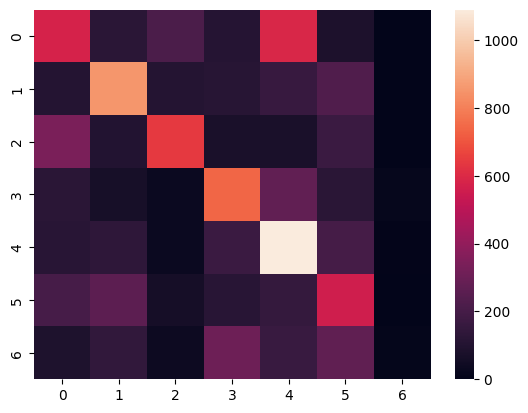

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,prediction))

After using our test data for predicting purposes, we can in the see the f-1 score for each end station and the confusion matrix that the model is relatively accurate given the complexity of the problem across most stations except for the last one, where we see an abnormaly low score in comparison. 

## Random tree forest classifier


The last part of this challenge will be comparing our previously analyzed classifier with a DecisionTreeClassifier. Since this one only uses binary decision-making with respect to each feature and our problem is of a high complexity, it is expected to perform far worse than a Neural Network.
Implementing this classifier is trivial given that all the data preparation has already been done in the previous section

In [47]:
from sklearn.tree import DecisionTreeClassifier


In [48]:
dt=DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt.score(x_test,y_test)


0.3046050685336752

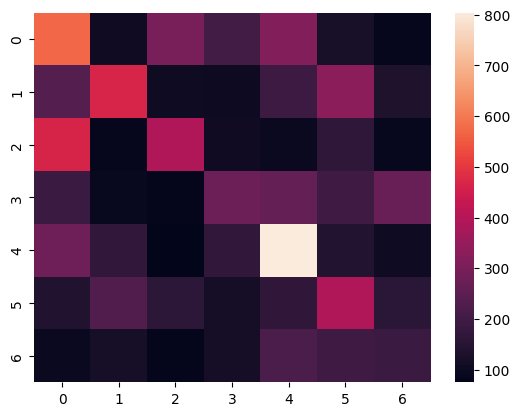

In [56]:
ypred=dt.predict(x_test)
sns.heatmap(confusion_matrix(y_test, ypred))
plt.show()

In [58]:
f1_score(y_test,ypred, average= None)

array([0.31078511, 0.33026874, 0.30382683, 0.22512235, 0.42326928,
       0.26915114, 0.18360334])

As can be seen in these metrics, the model perform far worse than the NN, which was expected.
However, the model's station per station metrics are quite different than the ones for the NN. For example, class 3 (corresponding to station 107) is predicted far worse than in the previous model, with class 6 being more accurate in relation to the average.